# Draft 1 - Figure 2

_Description of our goal:_  

a. Cone plots in select regions with obs. unc. to ICV unc. ratio, b. trends zeroed to ToE, and maybe c. evolution of obs. Unc.

In [28]:
import glob
import os

import numpy as np
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

import cartopy.crs as ccrs
import matplotlib.patheffects as pe

import copy

%matplotlib inline

In [29]:
def to_png(file, filename, loc='/glade/u/home/jonahshaw/figures/',dpi=200,ext='png',**kwargs):
    '''
    Simple function for one-line saving.
    Saves to "/glade/u/home/jonahshaw/figures" by default
    '''
    output_dir = loc
    full_path = '%s%s.%s' % (output_dir,filename,ext)

    if not os.path.exists(output_dir + filename):
        file.savefig(full_path,format=ext, dpi=dpi,**kwargs)
#         file.clf()
        
    else:
        print('File already exists, rename or delete.')

In [30]:
def compute_tte(
    obs_trends,
    pic_trends,
    startyear=1960,
):
    '''
    General function comparing the observed trends with the PIC trends to determine TTE.
    '''
    # Can only test up to the longest sampled duration of PI-Control or observations
    duration_limit = np.minimum(obs_trends.duration.max(), pic_trends.duration.max())

    dims = [i for i in obs_trends.dims if i in ["duration", "realization"]]
    availability_mask = ~np.isnan(obs_trends).any(dim=dims)
    
    _tte_bool = obs_trends > pic_trends
    _tte      = startyear + _tte_bool.duration.where(~_tte_bool).max(dim='duration')
    _tte      = _tte.where(_tte!=startyear + duration_limit, np.nan) # Mask the unemerged regions
    _tte      = _tte.where(availability_mask, np.nan) # Mask the unobserved regions
    _tte      = _tte.drop(['percentile'])
    
    return _tte

## Spatial (5x5 deg.) Data

### Load processed trend data

#### Models

In [31]:
# I need to go from the CAM output variables to the CMOR/CMIP standard names.
pic_tseries_dir = '/glade/work/jonahshaw/trend_uncertainty/nathan/CMIP6_PIC/'
cesm1_dir       = 'CESM1/'
mpi_dir         = 'MPI-GE/'
canesm2_dir     = 'CanESM2/'
esm2m_dir       = 'ESM2M/'

cesm1_cmor_var_dict = {'ts':'TS','tas':'TREFHT','psl':'PSL'}

Take percentiles from PI-Control Runs of models

In [32]:
cesm1_spatial_trends_filepath   = glob.glob('%s/%s/*5x5degSpatialTrends.3_120_years.Percentiles.nc' % (pic_tseries_dir,cesm1_dir))
mpi_spatial_trends_filepath     = glob.glob('%s/%s/*5x5degSpatialTrends.3_120_years.Percentiles.nc' % (pic_tseries_dir,mpi_dir))
canesm2_spatial_trends_filepath = glob.glob('%s/%s/*5x5degSpatialTrends.3_120_years.Percentiles.nc' % (pic_tseries_dir,canesm2_dir))
esm2m_spatial_trends_filepath   = glob.glob('%s/%s/*5x5degSpatialTrends.3_120_years.Percentiles.nc' % (pic_tseries_dir,esm2m_dir))

In [33]:
cesm1_regional_trends_filepath   = glob.glob('%s/%s/*.1900trends.Percentiles*.nc' % (pic_tseries_dir,cesm1_dir))
mpi_regional_trends_filepath     = glob.glob('%s/%s/*.1900trends.Percentiles*.nc' % (pic_tseries_dir,mpi_dir))
canesm2_regional_trends_filepath = glob.glob('%s/%s/*.1900trends.Percentiles*.nc' % (pic_tseries_dir,canesm2_dir))
esm2m_regional_trends_filepath   = glob.glob('%s/%s/*.1900trends.Percentiles*.nc' % (pic_tseries_dir,esm2m_dir))

Load the trend data.

In [34]:
cesm1_pic_spatial_trends_all   = xr.open_dataarray(*cesm1_spatial_trends_filepath)

mpi_pic_spatial_trends_all     = xr.open_dataarray(*mpi_spatial_trends_filepath)

canesm2_pic_spatial_trends_all = xr.open_dataarray(*canesm2_spatial_trends_filepath)

esm2m_pic_spatial_trends_all   = xr.open_dataarray(*esm2m_spatial_trends_filepath)

In [35]:
cesm1_pic_regional_trends_all   = xr.open_dataarray(*cesm1_regional_trends_filepath)

mpi_pic_regional_trends_all     = xr.open_dataarray(*mpi_regional_trends_filepath)

canesm2_pic_regional_trends_all = xr.open_dataarray(*canesm2_regional_trends_filepath)

esm2m_pic_regional_trends_all   = xr.open_dataarray(*esm2m_regional_trends_filepath)

#### Observations

And the OBS-LE is effectively used as a model so I just want the percentiles.

In [36]:
obs_tseries_dir = '/glade/work/jonahshaw/trend_uncertainty/nathan/OBS_LENS/'
gistemp_5x5_dir = 'GISTEMP_5x5/20240820/'
hadcrut5_dir    = 'HadCRUT5/20240820/'
obsle_dir       = 'mckinnon_OLENS/'

In [37]:
gistemp_tas_var = 'tas'
hadcrut5_tas_var = 'tas'
obsle_tas_var    = 'tas'

In [38]:
gistemp_5x5_spatial_trends_filepath  = glob.glob('%s/%s/*5x5degSpatialTrends.??????-??????.nc' % (obs_tseries_dir,gistemp_5x5_dir))
gistemp_5x5_spatial_trends_filepath.sort()
hadcrut5_spatial_trends_filepath     = glob.glob('%s/%s/*5x5degSpatialTrends.??????-??????.nc' % (obs_tseries_dir,hadcrut5_dir))
hadcrut5_spatial_trends_filepath.sort()
obsle_spatial_trends_filepath        = glob.glob('%s/%s/*.5x5*1921_1922.Percentiles*.nc' % (obs_tseries_dir,obsle_dir))

In [39]:
gistemp_5x5_regional_trends_filepath  = glob.glob('%s/%s/*trends.190001-202012*.nc' % (obs_tseries_dir,gistemp_5x5_dir))
hadcrut5_regional_trends_filepath     = glob.glob('%s/%s/*trends.190001-202212*.nc' % (obs_tseries_dir,hadcrut5_dir))
obsle_regional_trends_filepath        = glob.glob('%s/%s/*region*1921_1925.Percentiles*.nc' % (obs_tseries_dir,obsle_dir))

In [40]:
cesm1_regional_trends_filepath   = glob.glob('%s/%s/*.1900trends.Percentiles*.nc' % (pic_tseries_dir,cesm1_dir))
mpi_regional_trends_filepath     = glob.glob('%s/%s/*.1900trends.Percentiles*.nc' % (pic_tseries_dir,mpi_dir))
canesm2_regional_trends_filepath = glob.glob('%s/%s/*.1900trends.Percentiles*.nc' % (pic_tseries_dir,canesm2_dir))
esm2m_regional_trends_filepath   = glob.glob('%s/%s/*.1900trends.Percentiles*.nc' % (pic_tseries_dir,esm2m_dir))

Also load trend percentiles for cone plots

In [41]:
gistemp_5x5_spatial_trendpercs_filepath  = glob.glob('%s/%s/*Spatial*.Percentiles*.nc' % (obs_tseries_dir,gistemp_5x5_dir))
hadcrut5_spatial_trendpercs_filepath     = glob.glob('%s/%s/*Spatial*.Percentiles*.nc' % (obs_tseries_dir,hadcrut5_dir))

In [42]:
gistemp_regional_trendpercs_filepath  = glob.glob('%s/%s/*.190001-202012.trends.Percentiles*.nc' % (obs_tseries_dir,gistemp_5x5_dir))
hadcrut5_regional_trendpercs_filepath = glob.glob('%s/%s/*.190001-202012.trends.Percentiles*.nc' % (obs_tseries_dir,hadcrut5_dir))

Load the trend data

In [43]:
gistemp_5x5_spatial_trends_all  = xr.open_mfdataset(gistemp_5x5_spatial_trends_filepath).drop('startyear')['tas'].chunk({'realization': -1})
gistemp_5x5_spatial_trends_all['realization'] = gistemp_5x5_spatial_trends_all['realization'] - 1 # Shift back to 1
hadcrut5_spatial_trends_all     = xr.open_mfdataset(hadcrut5_spatial_trends_filepath).drop('startyear').rename({'longitude':'lon','latitude':'lat'})['tas'].chunk({'realization': -1})
obsle_spatial_trends_all        = xr.open_dataarray(*obsle_spatial_trends_filepath).compute()

In [44]:
gistemp_regional_trends_all  = xr.open_dataarray(*gistemp_5x5_regional_trends_filepath).sel(startyear=1900).drop('startyear')
hadcrut5_regional_trends_all     = xr.open_dataarray(*hadcrut5_regional_trends_filepath).sel(startyear=1900).drop('startyear')
obsle_regional_trends_all        = xr.open_dataarray(*obsle_regional_trends_filepath)

Load obs-le percentile data

In [45]:
gistemp_5x5_spatial_trendpercs_all  = xr.open_dataarray(*gistemp_5x5_spatial_trendpercs_filepath).drop('startyear')
hadcrut5_spatial_trendpercs_all     = xr.open_dataarray(*hadcrut5_spatial_trendpercs_filepath).drop('startyear') #.rename({'longitude':'lon','latitude':'lat'})

In [46]:
gistemp_regional_trendpercs_all  = xr.open_dataarray(*gistemp_regional_trendpercs_filepath).drop('startyear')
hadcrut5_regional_trendpercs_all     = xr.open_dataarray(*hadcrut5_regional_trendpercs_filepath).drop('startyear')

Create masks for screening mask availability.

In [47]:
# Mask member if there are any nans
gistemp_member_availability_mask = np.isnan(gistemp_5x5_spatial_trends_all).any(dim="duration").compute()
hadcrut_member_availability_mask = np.isnan(hadcrut5_spatial_trends_all).any(dim="duration").compute()

# Mask all if all individual members are masked.
gistemp_spatial_availability_mask = gistemp_member_availability_mask.all(dim="realization")
hadcrut_spatial_availability_mask = hadcrut_member_availability_mask.all(dim="realization")

# Mask before calculating ToE
gistemp_5x5_spatial_trends_masked = gistemp_5x5_spatial_trends_all.where(~gistemp_member_availability_mask)
hadcrut5_spatial_trends_masked = hadcrut5_spatial_trends_all.where(~hadcrut_member_availability_mask)

### Compute TTE generally

In [93]:
obs_spatial_trend_dict  = {'GISTEMP_5x5':gistemp_5x5_spatial_trends_masked,
                           'HadCRUT':hadcrut5_spatial_trends_masked}
obs_regional_trend_dict = {'GISTEMP_5x5':gistemp_regional_trends_all,
                           'HadCRUT':hadcrut5_regional_trends_all}
obs_trend_dict          = {'spatial':obs_spatial_trend_dict,
                           'regional':obs_regional_trend_dict}
obs_spatial_perc_dict = {
    "GISTEMP_5x5":gistemp_5x5_spatial_trendpercs_all,
    "HadCRUT":hadcrut5_spatial_trendpercs_all,
}
obs_regional_perc_dict = {
    "GISTEMP_5x5":gistemp_regional_trendpercs_all,
    "HadCRUT":hadcrut5_regional_trendpercs_all,
}
obs_perc_dict = {
    "spatial":obs_spatial_perc_dict,
    "regional":obs_regional_perc_dict,
}

model_spatial_trend_dict = {'CESM1':cesm1_pic_spatial_trends_all,
                            'MPI':mpi_pic_spatial_trends_all,
                            'CanESM2':canesm2_pic_spatial_trends_all,
                            'ESM2M':esm2m_pic_spatial_trends_all,
                            'OBS-LE':obsle_spatial_trends_all,
                           }

model_regional_trend_dict = {'CESM1':cesm1_pic_regional_trends_all,
                             'MPI':mpi_pic_regional_trends_all,
                             'CanESM2':canesm2_pic_regional_trends_all,
                             'ESM2M':esm2m_pic_regional_trends_all,
                             'OBS-LE':obsle_regional_trends_all,
                            }
                                         
model_trend_dict          = {'spatial':model_spatial_trend_dict,
                             'regional':model_regional_trend_dict}

Compute the TTE for each ensemble member separately.

In [49]:
%%time 

spatial_box = []
regional_box = []

# Iterate over regional vs. spatial
for _location_type in list(obs_trend_dict.keys()):
    
    print(_location_type)
    _box = spatial_box if (_location_type == 'spatial') else regional_box
    location_box = []
    
    _allobs_trends = obs_trend_dict[_location_type]
    _allmodel_trends = model_trend_dict[_location_type]
    
    for _obs_product in list(_allobs_trends.keys()):
        print(_obs_product)
        obs_box = []
        
        _obs_trends = _allobs_trends[_obs_product]
        
        for _model_product in list(_allmodel_trends.keys()):
            print(_model_product)
            _model_trends = _allmodel_trends[_model_product]
            
            # Compute ToE of the median trend (more consistent with using the 50%ile trend for mean)
            _mean_toe = compute_tte(
                obs_trends=_obs_trends.median(dim='realization'),
                pic_trends=_model_trends.sel(percentile=97.5),
                startyear=1900,
            )

            # Compute ToE for each ensemble member and take the 95th percentile
            _strict_toe = compute_tte(
                obs_trends=_obs_trends,
                pic_trends=_model_trends.sel(percentile=97.5),
                startyear=1900,
            )

            # Switch nans to infs in order to compute the strict ToE correctly. Then switch infs back to nans in order to mask correctly.
            _strict_toe = _strict_toe.where(~np.isnan(_strict_toe),np.inf).quantile(q=0.95,dim='realization',interpolation='nearest')
            _strict_toe = _strict_toe.where(~np.isinf(_strict_toe),np.nan)
            
            # Compute the delay and conditional delay mask:
            _delay_toe = _strict_toe - _mean_toe # Compute the delay
            _delay_undef_region = np.bitwise_and(np.isnan(_strict_toe), ~np.isnan(_mean_toe)) # Mask for where tas is emerged in the mean but not the "strict" sense.
            _delay_toe = xr.where(_delay_undef_region,2020 - _mean_toe,_delay_toe) # Apply the conditional mask

            _toes = xr.concat([_mean_toe.assign_coords({'metric':'mean'},).expand_dims(['metric'],axis=[-1]),
                               _strict_toe.assign_coords({'metric':'strict'},).expand_dims(['metric'],axis=[-1]),
                               _delay_toe.assign_coords({'metric':'delay'},).expand_dims(['metric'],axis=[-1]),
                               _delay_undef_region.assign_coords({'metric':'delay_mask'},).expand_dims(['metric'],axis=[-1]),
                              ],
                              dim='metric',
                             )            
                              
            obs_box.append(_toes.assign_coords({'model':_model_product},).expand_dims(['model'],axis=[-1]))
                        
        location_box.append(xr.concat(obs_box,dim='model').assign_coords({'obs':_obs_product},).expand_dims(['obs'],axis=[-1]))
    _box.append(xr.concat(location_box,dim='obs').compute())
    
spatial_masked_da = spatial_box[0]

spatial
GISTEMP_5x5
CESM1
MPI
CanESM2
ESM2M
OBS-LE
HadCRUT
CESM1
MPI
CanESM2
ESM2M
OBS-LE


/glade/work/jonahshaw/miniconda3/envs/cheydask/lib/python3.7/site-packages/dask/utils.py:31: RuntimeWarning: All-NaN slice encountered
  return func(*args, **kwargs)
/glade/work/jonahshaw/miniconda3/envs/cheydask/lib/python3.7/site-packages/dask/core.py:121: RuntimeWarning: All-NaN slice encountered
  return func(*(_execute_task(a, cache) for a in args))
/glade/work/jonahshaw/miniconda3/envs/cheydask/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1114: RuntimeWarning: All-NaN slice encountered
  overwrite_input=overwrite_input)


regional
GISTEMP_5x5
CESM1
MPI
CanESM2
ESM2M
OBS-LE
HadCRUT
CESM1
MPI
CanESM2
ESM2M
OBS-LE
CPU times: user 18.7 s, sys: 4.57 s, total: 23.3 s
Wall time: 34.1 s


In [50]:
cesm1_pic_95confspread   = cesm1_pic_regional_trends_all.sel(percentile=97.5) - cesm1_pic_regional_trends_all.sel(percentile=2.5)
gistemp_reg_95confspread = gistemp_regional_trendpercs_all.sel(percentile=97.5) - gistemp_regional_trendpercs_all.sel(percentile=2.5)

gistemp_cesm1_uncratio = gistemp_reg_95confspread / cesm1_pic_95confspread

In [51]:
gistemp_5x5_trends_50perc_reindex = gistemp_regional_trendpercs_all.sel(percentile=50.0).copy()
regional_tte_data = regional_box[0]

mean_tte  = regional_tte_data.sel(model='CESM1',obs='GISTEMP_5x5',metric='mean')
strict_tte = regional_tte_data.sel(model='CESM1',obs='GISTEMP_5x5',metric='strict')

startyear = 1900

reindexed_trends = []
for region_index in gistemp_5x5_trends_50perc_reindex.RegionIndex:

    region_trends = gistemp_5x5_trends_50perc_reindex.sel(RegionIndex=region_index)
    region_mean_tte = mean_tte.sel(RegionIndex=region_index)
    
    region_trends['years_since_emerge'] = startyear + region_trends.duration - 1 - region_mean_tte
    
    reindexed_trends.append(region_trends)    

reindexed_trends_concat = xr.concat(reindexed_trends,dim='RegionIndex')

In [52]:
mean_delay_trends = []

for delay in range(int(reindexed_trends_concat.years_since_emerge.min()),int(reindexed_trends_concat.years_since_emerge.max())):
    
    delay_mean_value = reindexed_trends_concat.where(reindexed_trends_concat.years_since_emerge==delay).mean()
    
    mean_delay_trends.append(delay_mean_value.values)

delay_range = np.arange(int(reindexed_trends_concat.years_since_emerge.min()),int(reindexed_trends_concat.years_since_emerge.max()))

delay_da = xr.DataArray(
    data=mean_delay_trends,
    dims=["delay",],
    coords={'delay':delay_range}
)

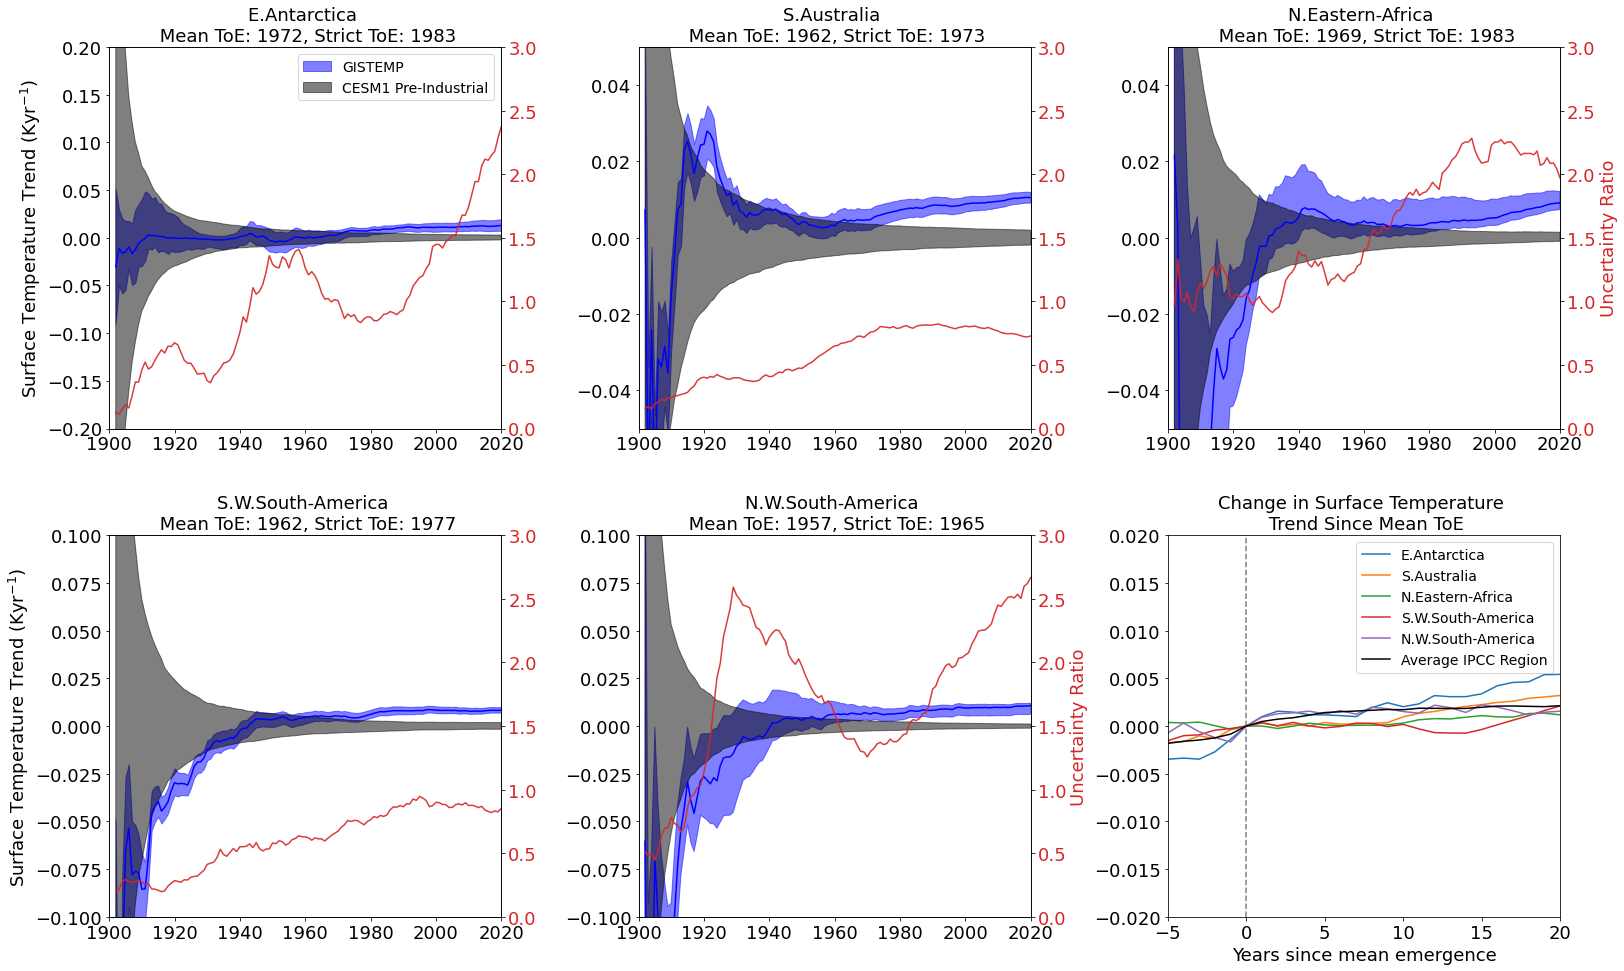

In [53]:
fig,axs = plt.subplots(2,3,figsize=(26,16))
axs = axs.flat

fig.subplots_adjust(hspace=0.28,wspace=0.35)

# Set values here:
region_indices = [44,42,23,13,9]
region_ylims   = [[-0.2,0.2],[-0.05,0.05],[-0.05,0.05],[-0.1,0.1],[-0.1,0.1],]
startyear = 1900

obs_percentile_data   = gistemp_regional_trendpercs_all
model_percentile_data = cesm1_pic_regional_trends_all

year_gistemp = startyear + obs_percentile_data.duration - 1
year_cesm1   = startyear + model_percentile_data.duration - 1

axs2 = []

for region_index,ylim,ax in zip(region_indices,region_ylims,axs):
    
    # Compute the mean and strict ToEs
    _mean_tte        = mean_tte.sel(RegionIndex=region_index)
    _strict_tte      = strict_tte.sel(RegionIndex=region_index)
    _gistemp_cesm1_uncratio = gistemp_cesm1_uncratio.sel(RegionIndex=region_index)
    
    if (_strict_tte == 2020): _strict_tte = np.nan #xr.where(part_undef_gistemp,2020 - mean_tte_gistemp,np.nan)

    ax.fill_between(year_gistemp,
                    obs_percentile_data.sel(percentile=2.5,RegionIndex=region_index),
                    obs_percentile_data.sel(percentile=97.5,RegionIndex=region_index),
                    color='blue',
                    alpha=0.5,
                    label='GISTEMP',
                   )

    ax.fill_between(year_cesm1,
                    model_percentile_data.sel(percentile=2.5,RegionIndex=region_index),
                    model_percentile_data.sel(percentile=97.5,RegionIndex=region_index),
                    # cesm1_pic_trends_97_5perc.sel(RegionIndex=region_index),
                    color='black',
                    alpha=0.5,
                    label='CESM1 Pre-Industrial',
                   )

    ax.plot(year_gistemp,
            obs_percentile_data.sel(percentile=50.0,RegionIndex=region_index),
            color='blue'
           )

    ax.tick_params(axis='both', labelsize=18)

    # ax.set_ylabel('Surface Temperature Trend (Kyr$^{-1}$)',fontsize=18)
    # ax.set_xlabel('Year',fontsize=18)

    ax.set_xlim(startyear, 2020)
    # ax.set_xlim(1963,2020)
    ax.set_ylim(ylim)
    
    # Set up another y-axis on the right side of the plot
    ax2 = ax.twinx()  # instantiate a second axes that shares the same x-axis

    color = 'tab:red'
    # ax2.set_ylabel('Uncertainty Ratio', color=color,fontsize=18)  # we already handled the x-label with ax1
    ax2.plot(
        startyear + gistemp_cesm1_uncratio.duration - 1,
        _gistemp_cesm1_uncratio,
        color=color,
        alpha=0.9,
    )#,linestyle='dashed')
    ax2.set_ylim([0,3])
    ax2.tick_params(axis='y', labelcolor=color,labelsize=18)        

    title_p1 = str(obs_percentile_data.sel(RegionIndex=region_index).RegionName.values)
    if np.isnan(_strict_tte):
        title_p2 = 'Mean ToE: %d, Strict ToE: None' % (_mean_tte)
    else:
        title_p2 = 'Mean ToE: %d, Strict ToE: %d' % (_mean_tte,_strict_tte)
    # title_p2 = 'Mean ToE: %d, Strict ToE: %s' % (_mean_tte.values,_strict_tte.values)
    # title_p2 = 'Mean ToE: %d, Strict ToE: %d' % (mean_tte,strict_tte)
    # title_p2 = 'Mean ToE: %d, Strict ToE: %s' % (mean_tte,str(np.round(strict_tte.values,0)))

    ax.set_title('%s \n %s' % (title_p1,title_p2),fontsize=18)
    
    axs2.append(ax2)

axs[0].set_ylabel('Surface Temperature Trend (Kyr$^{-1}$)',fontsize=18)
axs[3].set_ylabel('Surface Temperature Trend (Kyr$^{-1}$)',fontsize=18)

axs2[2].set_ylabel('Uncertainty Ratio', color=color,fontsize=18)
axs2[4].set_ylabel('Uncertainty Ratio', color=color,fontsize=18)
# axs2[5].set_ylabel('Uncertainty Ratio', color=color,fontsize=18)

axs[0].legend(fontsize=14)
    
for region_index in region_indices:
    
    # Plot the trends shifted to the time of emergence
    region_trends = obs_percentile_data.sel(percentile=50.0,RegionIndex=region_index) # Select region
    region_mean_tte = mean_tte.sel(RegionIndex=region_index) # Get ToE
    duration_at_emergence = region_mean_tte-startyear+1 # Get the duration of trends at ToE
    region_trends_corrected = region_trends - region_trends.sel(duration=duration_at_emergence) # shift the trends to the ToE year
            
    # Correct for the trends changing 
    year_from_toe = startyear + region_trends_corrected.duration - 1 # shift the year to the ToE year
    axs[5].plot(year_from_toe - region_mean_tte,region_trends_corrected,label=region_trends_corrected.RegionName.values)    

axs[5].plot(delay_da.delay,delay_da-delay_da.sel(delay=0),color='black',label='Average IPCC Region')
    
axs[5].vlines(0,-0.02,0.05,color='grey',linestyle='dashed',zorder=-1)
axs[5].set_xlim(-5,20)
axs[5].set_ylim(-0.02,0.02)

axs[5].set_xlabel('Years since mean emergence',fontsize=18)
# axs[5].set_ylabel('Change in Surface Temperature Trend Since Emergence (Kyr$^{-1}$)',fontsize=18)
axs[5].set_title('Change in Surface Temperature \n Trend Since Mean ToE',fontsize=18)
axs[5].tick_params(axis='both',labelsize=18)        

axs[5].legend(fontsize=14)

In [24]:
# to_png(file=fig,filename='draft3_fig2_cones',dpi=300,ext='png',bbox_inches='tight') # or .pdf 

In [81]:
def create_coneplot(
    obs_percentiles: xr.DataArray,
    model_percentiles: xr.DataArray,
    obs_times: xr.DataArray,
    model_times: xr.DataArray,
    mean_tte: xr.DataArray,
    strict_tte: xr.DataArray,
    uncertainty_ratio: xr.DataArray=None,
    startyear: int=1900,
    title: str=None,
    ylim: tuple=None,
):

    fig,ax = plt.subplots(1,1,figsize=(8,8))
    
    if (strict_tte == 2020): strict_tte = np.nan
    
    ax.fill_between(
        obs_times,
        obs_percentiles.sel(percentile=2.5),
        obs_percentiles.sel(percentile=97.5),
        color='blue',
        alpha=0.5,
        label=str(mean_tte.obs.values),
    )
    
    ax.fill_between(
        model_times,
        model_percentiles.sel(percentile=2.5),
        model_percentiles.sel(percentile=97.5),
        color='black',
        alpha=0.5,
        label=str(mean_tte.model.values),
    )
    
    ax.plot(
        obs_times,
        obs_percentiles.sel(percentile=50.0),
        color='blue'
    )
    
    ax.tick_params(axis='both', labelsize=18)
    
    ax.set_xlim(startyear, 2020)
    if ylim is not None:
        ax.set_ylim(ylim)      

    if np.isnan(strict_tte) and np.isnan(mean_tte):
        title_p2 = 'Mean ToE: None, Strict ToE: None'
    elif np.isnan(strict_tte):
        title_p2 = 'Mean ToE: %d, Strict ToE: None' % (mean_tte)
    else:
        title_p2 = 'Mean ToE: %d, Strict ToE: %d' % (mean_tte, strict_tte)
    
    if title is not None:
        ax.set_title(f"{title} \n {title_p2}", fontsize=18)
    else:
        ax.set_title(f"{title_p2}", fontsize=18)
    ax.set_ylabel('Surface Temperature Trend (Kyr$^{-1}$)',fontsize=18)
    
    if uncertainty_ratio is not None:
        # Set up another y-axis on the right side of the plot
        ax2 = ax.twinx()  # instantiate a second axes that shares the same x-axis
        
        color = 'tab:red'
        ax2.plot(
            startyear + uncertainty_ratio.duration - 1,
            uncertainty_ratio,
            color=color,
            alpha=0.9,
        )
        ax2.set_ylim([0,3])
        ax2.tick_params(axis='y', labelcolor=color,labelsize=18)  
        ax2.set_ylabel('Uncertainty Ratio', color=color,fontsize=18)
        axs2.append(ax2)

    return fig

Create coneplot for lat-lon locations.  
Example: Super early emergence in the Atlantic around -7 deg. lat, -18 deg. lon

In [82]:
cesm1_5x5_95confspread   = cesm1_pic_spatial_trends_all.sel(percentile=97.5) - cesm1_pic_spatial_trends_all.sel(percentile=2.5)
gistemp_5x5_95confspread = gistemp_5x5_spatial_trendpercs_all.sel(percentile=97.5) - gistemp_5x5_spatial_trendpercs_all.sel(percentile=2.5)

gistemp_cesm1_5x5_uncratio = gistemp_5x5_95confspread / cesm1_5x5_95confspread

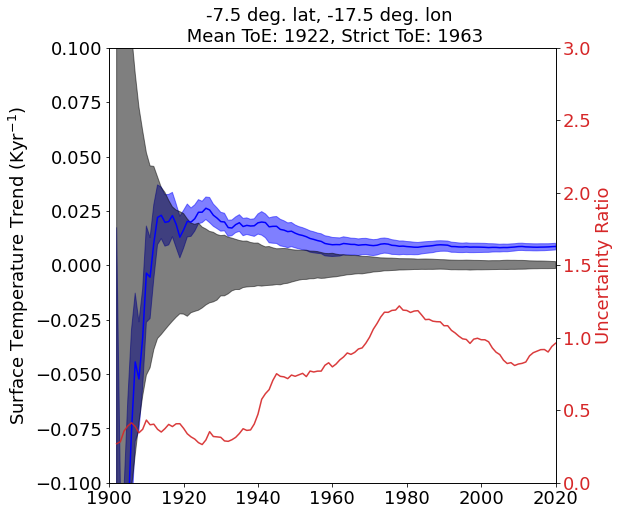

In [99]:
startyear = 1900
model="ESM2M"
obs="GISTEMP_5x5"

target_lat = -7 #55
target_lon = -18 #-31

obs_95conf = obs_spatial_perc_dict[obs].sel(percentile=97.5) - obs_spatial_perc_dict[obs].sel(percentile=2.5)
model_95conf = model_spatial_trend_dict[model].sel(percentile=97.5) - model_spatial_trend_dict[model].sel(percentile=2.5)
uncertainty_ratio = obs_95conf / model_95conf

obs_percentile_data   = obs_spatial_perc_dict[obs] #gistemp_regional_trendpercs_all # hadcrut5_regional_trendpercs_all
model_percentile_data = model_spatial_trend_dict[model]

year_gistemp = startyear + obs_percentile_data.duration - 1
year_cesm1   = startyear + model_percentile_data.duration - 1

mean_tte_spatial = spatial_masked_da.sel(
    metric="mean",
    model=model,
    obs=obs,
)
strict_tte_spatial = spatial_masked_da.sel(
    metric="strict",
    model=model,
    obs=obs,
)

# Compute the mean and strict ToEs
_mean_tte = mean_tte_spatial.sel(
    lat=target_lat,
    lon=target_lon,
    method="nearest",
)
_strict_tte = strict_tte_spatial.sel(
    lat=target_lat,
    lon=target_lon,
    method="nearest",
)
_uncratio = uncertainty_ratio.sel(
    lat=target_lat,
    lon=target_lon,
    method="nearest",
)
_obs_percentile_data = obs_percentile_data.sel(
    lat=target_lat,
    lon=target_lon,
    method="nearest",
)
_model_percentile_data = model_percentile_data.sel(
    lat=target_lat,
    lon=target_lon,
    method="nearest",
)

fig = create_coneplot(
    obs_percentiles=_obs_percentile_data,
    model_percentiles=_model_percentile_data,
    obs_times=year_gistemp,
    model_times=year_cesm1,
    mean_tte=_mean_tte,
    strict_tte=_strict_tte,
    uncertainty_ratio=_uncratio,
    ylim=[-0.1, 0.1],
    title=f"{_mean_tte.lat.values} deg. lat, {_mean_tte.lon.values} deg. lon",
)

Create coneplots for all IPCC regions:

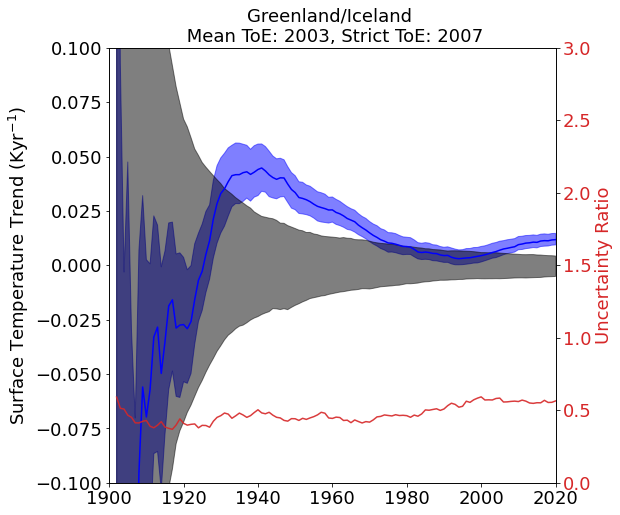

In [65]:
startyear = 1900

obs_percentile_data   = gistemp_regional_trendpercs_all #gistemp_regional_trendpercs_all # hadcrut5_regional_trendpercs_all
model_percentile_data = cesm1_pic_regional_trends_all

year_gistemp = startyear + obs_percentile_data.duration - 1
year_cesm1   = startyear + model_percentile_data.duration - 1

for region_index in obs_percentile_data.RegionIndex:

    # Compute the mean and strict ToEs
    _mean_tte        = mean_tte.sel(RegionIndex=region_index)
    _strict_tte      = strict_tte.sel(RegionIndex=region_index)
    _gistemp_cesm1_uncratio = gistemp_cesm1_uncratio.sel(RegionIndex=region_index)
    _obs_percentile_data = obs_percentile_data.sel(RegionIndex=region_index)
    _model_percentile_data = model_percentile_data.sel(RegionIndex=region_index)
    
    fig = create_coneplot(
        obs_percentiles=_obs_percentile_data,
        model_percentiles=_model_percentile_data,
        obs_times=year_gistemp,
        model_times=year_cesm1,
        mean_tte=_mean_tte,
        strict_tte=_strict_tte,
        uncertainty_ratio=_gistemp_cesm1_uncratio,
        ylim=[-0.1, 0.1],
        title=str(_mean_tte.RegionName.values)
    )

    break
    regionname = str(_mean_tte.RegionName.values).replace("/", "_")
    regionindex = str(_mean_tte.RegionIndex.values)
    _filename = f"coneplot2_Region{regionindex}_{regionname}"
        
    to_png(
        file=fig,
        filename=_filename,
        dpi=300,
        ext='pdf',
        bbox_inches='tight',
        loc='/glade/u/home/jonahshaw/figures/coneplots/'
    ) # or .pdf 